In [1]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')


In the contralateral hemisphere, average the bimanual activity when a hand moved to a certain direction (e.g., leftHand-rightHand: 0-0, 0-60, 0-120, 0-180, 0-240, 0-300) with the unimanual condittion in which that hand moved to the same direction (e.g., leftHand 0).

## Left hand reach in Right Hem

In [12]:
glm = 1
region_labels = [1, 2, 3, 4, 5, 6, 7, 8]
region_names = ['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp']
sn_list = [101,102,103,104,106,107,108,109,110,111,112,113,114,115]
hem = ['R']
atlas,_ = am.get_atlas('fs32k')
ana = {'sn':[], 
       'hem':[],
       'region':[],
       'cond':[],
       'G_hat':[],
       'D':[]}

for sn in sn_list:
    regressor_info = pd.read_table(os.path.join(baseDir, f'glm{glm}', f's{sn}', 'reginfo.tsv'))
    partitions = regressor_info['run'].values.flatten()
    conds = regressor_info['name'].values.flatten()

    for j, h in enumerate(hem):
        # ==========================================
        # DATA EXTRACTION
        # ==========================================
        #  Define atlas map
        white = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.white.32k.surf.gii') # Individual white surface
        pial = os.path.join(baseDir, surfacewbDir, f's{sn}', f's{sn}.{h}.pial.32k.surf.gii') # Invividual pial surface
        mask = os.path.join(baseDir, f'glm{glm}', f's{sn}', 'mask.nii') # Mask in functional space for that subject

        # File names for data extraction
        nii_names = sorted(glob.glob(os.path.join(baseDir, f'glm{glm}', f's{sn}', "beta_*.nii")))
        nii_names = nii_names[0:480] # remove the run constant regressors
        resMS_name = [os.path.join(baseDir, f'glm{glm}', f's{sn}', 'ResMS.nii')]
        
        beta = []
        resMS = []
        beta_white = []
        for i, r in enumerate(region_labels):
            atlas_tmp = atlas.get_hemisphere(j)
            subatlas = atlas_tmp.get_subatlas_image(os.path.join(atlasDir,f'ROI.32k.{h}.label.gii'), value=r)
            amap = am.AtlasMapSurf(subatlas.vertex[0],white,pial,mask) # Atlas map
            # Compute the voxels in native space
            amap.build()

            # This extract all the relevant voxels in native space (use for RSA)
            beta = amap.extract_data_native(nii_names)
            idx_nan = np.isnan(beta).any(axis=0)
            beta = beta[:, ~idx_nan]
            resMS = amap.extract_data_native(resMS_name)
            resMS = resMS[:, ~idx_nan]
            beta_white = beta/np.sqrt(resMS)
            
            # ========================================== 
            # Estimated variance-covariance matrix
            # ==========================================
            cond_vec = []
            part_vec = np.array([], dtype=int)
            Y = []
            for angle in [0,60,120,180,240,300]:
                # unimanual:
                idx = [(f'lhand:{angle}' in tmp) for tmp in conds]
                cond_vec.extend([cond.strip() for cond in np.array(conds)[idx]])
                part_vec = np.concatenate((part_vec,partitions[idx]))
                Y = np.vstack((Y, beta_white[idx,:])) if len(Y) else beta_white[idx,:]

                # bimanual:
                # idx = np.zeros(len(conds), dtype=bool)
                
                for k in range(1,11):
                    idx1 = np.array([(f'bi:{angle}' in tmp) for tmp in conds])
                    idx2 = np.array([(k == tmp) for tmp in partitions])
                    idx = idx1 & idx2
                    y_tmp = np.mean(beta_white[idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp))
                part_vec = np.concatenate((part_vec,np.arange(1,11)))
                cond_vec.extend([f'bi:{angle}'] * 10)
                
            cond_vec = np.array(cond_vec)
            # Y = beta_white[idx,:]
            # cond_vec = conds[idx]
            # partition_vec = partitions[idx]
            G_hat,_ = pcm.est_G_crossval(Y,
                                         cond_vec,
                                         part_vec,
                                         X=pcm.matrix.indicator(part_vec))
            D = np.sign(pcm.G_to_dist(G_hat)) * np.sqrt(np.abs(pcm.G_to_dist(G_hat)))
            
            ana['sn'].append(sn)
            ana['hem'].append(h)
            ana['region'].append(region_names[i])
            ana['cond'].append(cond_vec)

            # G_hat, indices = utils.please.matrix_to_vector(G_hat, include_diagonal=True)
            # D,_ = utils.please.matrix_to_vector(D, include_diagonal=True)
            # ana['row'] = indices[0]
            # ana['col'] = indices[1]
            ana['G_hat'].append(G_hat)
            ana['D'].append(D)

ana = pd.DataFrame(ana)
# ana.to_csv(os.path.join(analysisDir,'G_uni.csv'), index=False)


### PLOT G MATRIX 12x12

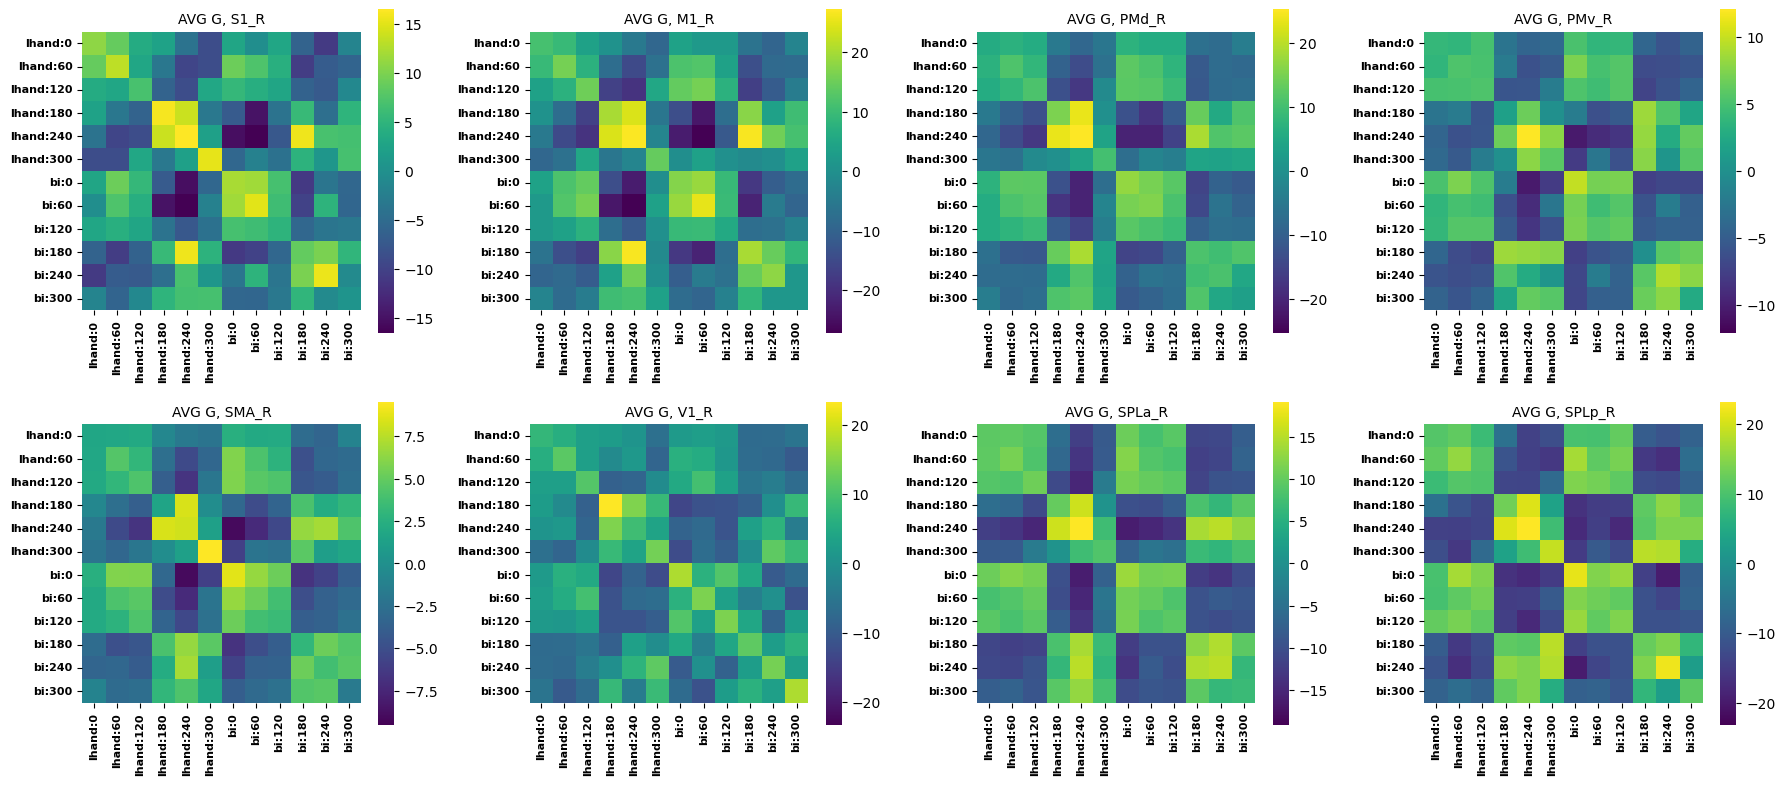

In [ ]:
sn_list = ana.sn.unique()
hem = ana.hem.unique()
regions = ana.region.unique()

conds = ['lhand:0', 'bi:0', 'lhand:60', 'bi:60', 'lhand:120', 'bi:120',
         'lhand:180', 'bi:180', 'lhand:240', 'bi:240', 'lhand:300', 'bi:300']
custom_order = ['lhand:0', 'lhand:60', 'lhand:120', 'lhand:180', 'lhand:240', 'lhand:300',
                'bi:0', 'bi:60', 'bi:120', 'bi:180', 'bi:240', 'bi:300']
# Create a mapping of the current order to their indices
order_map = {cond: idx for idx, cond in enumerate(conds)}
# Get the indices for the custom order
sort_indices = [order_map[cond] for cond in custom_order]

G_avg = np.zeros((len(hem),len(regions), len(conds), len(conds)))
n_cond = len(conds)
for sn in sn_list:
    for j, h in enumerate(hem):
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8))
        for i, ax in enumerate(axes.flat):
            # Apply sorting to the data
            G_hat = ana[(ana.sn==sn) & (ana.hem==h) & (ana.region==regions[i])].G_hat.values[0]
            G_hat = G_hat[np.ix_(sort_indices, sort_indices)]
            v_max = np.max(G_hat)
            v_min = np.min(G_hat)
            v_max = max(abs(v_max), abs(v_min))
            sns.heatmap(G_hat, cmap='viridis', square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
            ax.set_title(f'G, {region_names[i]}_{h}, s{sn}', fontsize=10)
            
            # Overlay squares
            # for x, y, w, h in squares:
            #     rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='black', facecolor='none')
            #     ax.add_patch(rect)

            # Set labels manually with more formatting options
            ax.set_xticks(np.arange(0,n_cond)+0.5)
            ax.set_xticklabels(custom_order, rotation=90, fontsize=8, fontweight='bold')
            ax.set_yticks(np.arange(0,n_cond)+0.5)
            ax.set_yticklabels(custom_order, rotation=0, fontsize=8, fontweight='bold')

            G_avg[j,i,:,:] = G_avg[j,i,:,:] + G_hat/len(sn_list)
        
        plt.tight_layout()
        # plt.savefig(f'../figures/G_mat_uni/G_hem{h}_s{sn}.pdf', bbox_inches="tight")
        plt.close()

# AVG G PLOT:
for j, h in enumerate(hem):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8))
    for i, ax in enumerate(axes.flat):
        # Apply sorting to the data
        G_hat = G_avg[j,i,:,:]
        v_max = np.max(G_hat)
        v_min = np.min(G_hat)
        v_max = max(abs(v_max), abs(v_min))
        sns.heatmap(G_hat, cmap='viridis', square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
        ax.set_title(f'AVG G, {region_names[i]}_{h}', fontsize=10)
        # Overlay squares
        # for x, y, w, h in squares:
        #     rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='black', facecolor='none')
        #     ax.add_patch(rect)

        # Set labels manually with more formatting options
        ax.set_xticks(np.arange(0,n_cond)+0.5)
        ax.set_xticklabels(custom_order, rotation=90, fontsize=8, fontweight='bold')
        ax.set_yticks(np.arange(0,n_cond)+0.5)
        ax.set_yticklabels(custom_order, rotation=0, fontsize=8, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f'../figures/G_mat_uni/G_avg_hem{h}.pdf', bbox_inches="tight")
    plt.show()



### PLOT D MATRIX 12x12

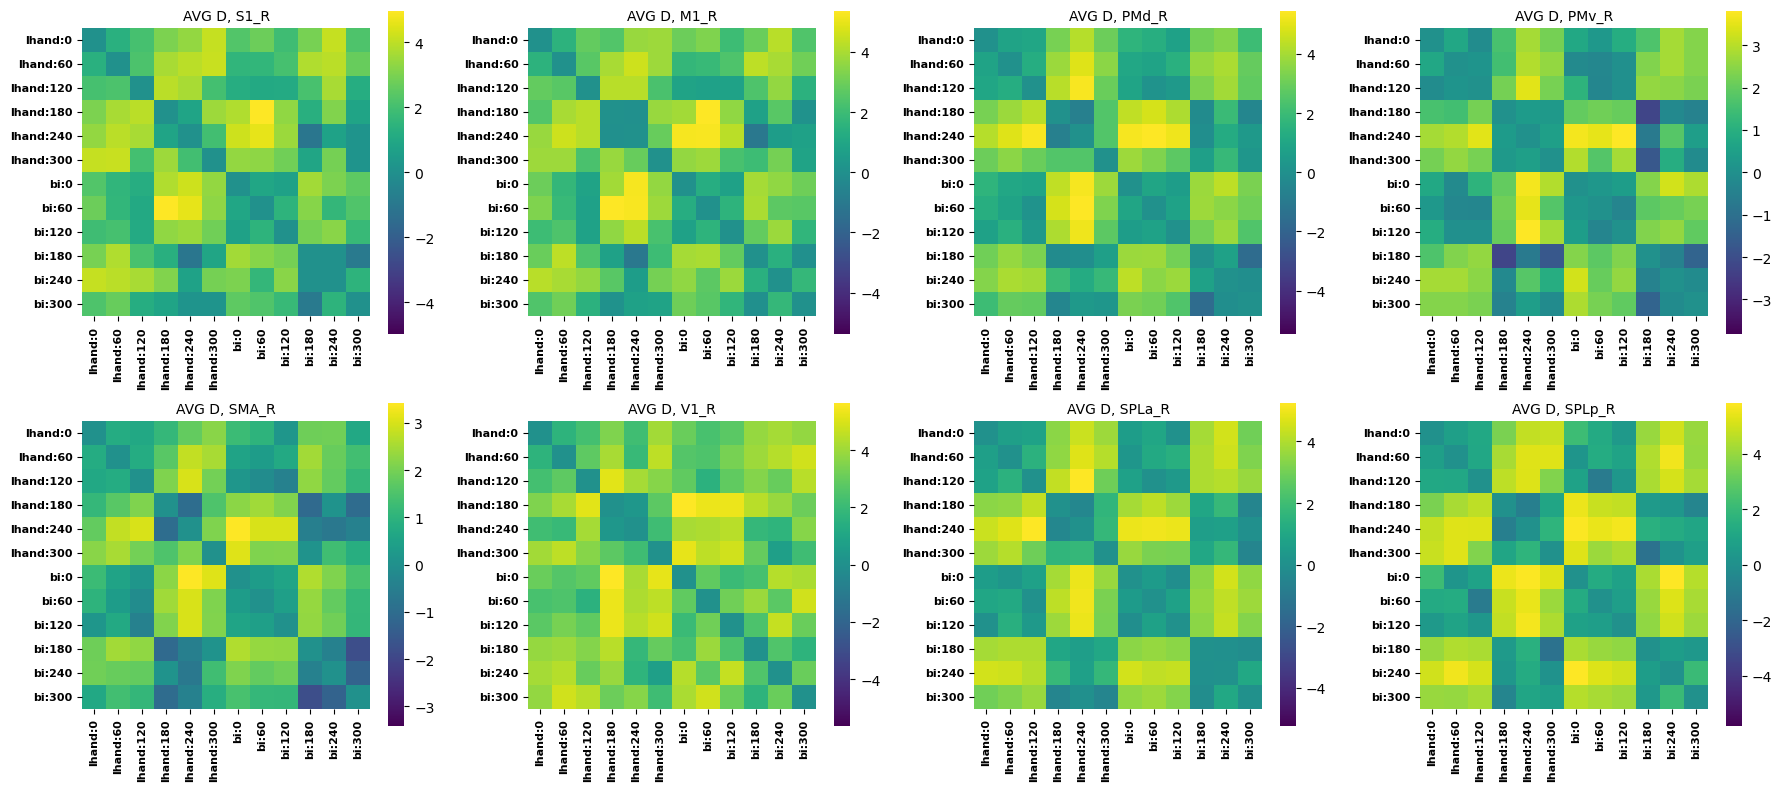

In [15]:
sn_list = ana.sn.unique()
hem = ana.hem.unique()
regions = ana.region.unique()

conds = ['lhand:0', 'bi:0', 'lhand:60', 'bi:60', 'lhand:120', 'bi:120',
         'lhand:180', 'bi:180', 'lhand:240', 'bi:240', 'lhand:300', 'bi:300']
custom_order = ['lhand:0', 'lhand:60', 'lhand:120', 'lhand:180', 'lhand:240', 'lhand:300',
                'bi:0', 'bi:60', 'bi:120', 'bi:180', 'bi:240', 'bi:300']
# Create a mapping of the current order to their indices
order_map = {cond: idx for idx, cond in enumerate(conds)}
# Get the indices for the custom order
sort_indices = [order_map[cond] for cond in custom_order]

D_avg = np.zeros((len(hem),len(regions), len(conds), len(conds)))
n_cond = len(conds)
for sn in sn_list:
    for j, h in enumerate(hem):
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8))
        for i, ax in enumerate(axes.flat):
            # Apply sorting to the data
            D = ana[(ana.sn==sn) & (ana.hem==h) & (ana.region==regions[i])].D.values[0]
            D = D[np.ix_(sort_indices, sort_indices)]
            v_max = np.max(D)
            v_min = np.min(D)
            v_max = max(abs(v_max), abs(v_min))
            sns.heatmap(D, cmap='viridis', square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
            ax.set_title(f'D, {region_names[i]}_{h}, s{sn}', fontsize=10)
            
            # Overlay squares
            # for x, y, w, h in squares:
            #     rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='black', facecolor='none')
            #     ax.add_patch(rect)

            # Set labels manually with more formatting options
            ax.set_xticks(np.arange(0,n_cond)+0.5)
            ax.set_xticklabels(custom_order, rotation=90, fontsize=8, fontweight='bold')
            ax.set_yticks(np.arange(0,n_cond)+0.5)
            ax.set_yticklabels(custom_order, rotation=0, fontsize=8, fontweight='bold')

            D_avg[j,i,:,:] = D_avg[j,i,:,:] + D/len(sn_list)
        
        plt.tight_layout()
        # plt.savefig(f'../figures/D_mat_uni/D_hem{h}_s{sn}.pdf', bbox_inches="tight")
        plt.close()

# AVG G PLOT:
for j, h in enumerate(hem):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8))
    for i, ax in enumerate(axes.flat):
        # Apply sorting to the data
        D = D_avg[j,i,:,:]
        v_max = np.max(D)
        v_min = np.min(D)
        v_max = max(abs(v_max), abs(v_min))
        sns.heatmap(D, cmap='viridis', square=True, cbar_kws={'label': ''}, ax=ax, vmin=-v_max, vmax=v_max)
        ax.set_title(f'AVG D, {region_names[i]}_{h}', fontsize=10)
        # Overlay squares
        # for x, y, w, h in squares:
        #     rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='black', facecolor='none')
        #     ax.add_patch(rect)
        
        # Set labels manually with more formatting options
        ax.set_xticks(np.arange(0,n_cond)+0.5)
        ax.set_xticklabels(custom_order, rotation=90, fontsize=8, fontweight='bold')
        ax.set_yticks(np.arange(0,n_cond)+0.5)
        ax.set_yticklabels(custom_order, rotation=0, fontsize=8, fontweight='bold')
    plt.tight_layout()
    # plt.savefig(f'../figures/D_mat_uni/D_avg_hem{h}.pdf', bbox_inches="tight")
    plt.show()

